# Images

## Librairies

In [48]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from IPython.core.display import HTML
from sklearn import preprocessing, cluster, metrics, manifold, decomposition
from matplotlib.image import imread
import cv2
import time
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import pickle

## Settings

In [5]:
%matplotlib inline
plt.style.use("dark_background")

## Chemins

In [6]:
path = "./data/"
photo_desc_filename = "photos.json"
path_to_photo_desc = path + photo_desc_filename
path_to_photos = path + "photos/"
sav_path = "./sav/"
dash_prefix = "DASH_"

## Import du dataset

In [7]:
def import_photos_desc(path_to_json, verbose=False):
    df_photos_desc = pd.read_json(
        (path_to_json),
        lines=True
    )
    if verbose:
        print("Les descriptions des photos ont été importées.")
        print("Nous avons la description de {} photos".format(df_photos_desc.shape[0]))
    return df_photos_desc

def import_photos(path):
    ls_photos = [f for f in listdir(path)]
    print("{} photos importées".format(len(ls_photos)))
    return ls_photos

def photo_preview(df, nb_by_cat=3):
    ls_lbls = df["label"].unique().tolist()
    df_preview = df.groupby("label").head(nb_by_cat).sort_values(by="label").reset_index(drop=True)
    for lbl in ls_lbls:
        df_cat = df_preview[df_preview["label"]==lbl].reset_index(drop=True)
        fig, ax = plt.subplots(ncols=nb_by_cat)
        fig.tight_layout()
        plt.title("Apperçu de la catégorie {}".format(lbl), y=1.5)
        for i in range(nb_by_cat):
            plt.subplot(130 + 1 + i)
            filepath = df_cat.iloc[i]["image"]
            pic = cv2.imread(filepath)
            plt.imshow(pic)
        plt.show()

def import_and_sample(
    path_to_photo_desc,
    path_to_photo,
    sample=None,
    verbose=False,
    plot=False,
    preview=False
):
    if verbose:
        display(HTML("<h1>Importation des photos</h1>"))
    # importation de la description des photos
    df_photos_desc = import_photos_desc(
        path_to_photo_desc, 
        verbose=verbose
    )
    ls_labels = df_photos_desc["label"].unique().tolist()
    if verbose:
        print("Apperçu :")
        display(df_photos_desc.head())
        display(HTML("<h2>Répartition des labels</h2>"))
        print("Il y a {} labels différents, qui sont :".format(len(ls_labels)))
        for label in ls_labels:
            print(label)
        print("Voici la répartition des labels :")
        df_photos_desc["label"].value_counts()
    if plot:
        df_photos_desc["label"].value_counts().plot(
            kind="pie",
            figsize=(10,10),
            autopct="%1.1f%%",
            title="Répartition des catégories de photos"
        )
        plt.show()
    # echantillonage
    if sample is not None:
        display(HTML("<h1>Echantillonage</h1>"))
        print("Echantillonage de {} descriptions pour chacun des {} labels".format(sample,len(ls_labels)))
        df_photos_desc = df_photos_desc.groupby("label").head(sample).reset_index(drop=True)
        if verbose:
            print("L'échantillon comporte {} lignes".format(df_photos_desc.shape[0]))
            print("Soit, par catégorie :")
            print(df_photos_desc["label"].value_counts())
        if plot:
            df_photos_desc["label"].value_counts().plot(
                kind="pie",
                figsize=(10,10),
                autopct="%1.1f%%",
                title="Répartition des catégories de photos de l'échantillon"
            )
            plt.show()
    # chargement des photos
    ls_photos = import_photos(path_to_photo)
    ls_photos_smpl = [f for f in listdir(path_to_photos) and df_photos_desc["photo_id"]]
    df_photos_desc["image"] = ls_photos_smpl
    df_photos_desc["image"]  = path_to_photo + df_photos_desc["image"] + ".jpg"
    if preview:
        display(HTML("<h1>Preview des photos par catégorie</h1>"))
        photo_preview(df_photos_desc, nb_by_cat=3)
    return df_photos_desc

Les descriptions des photos ont été importées.
Nous avons la description de 200100 photos
Apperçu :


,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


Il y a 5 labels différents, qui sont :
inside
outside
drink
food
menu
Voici la répartition des labels :


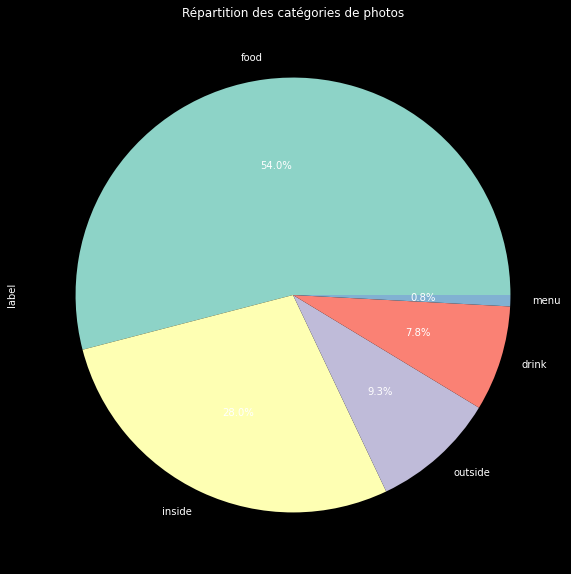

Echantillonage de 100 descriptions pour chacun des 5 labels
L'échantillon comporte 500 lignes
Soit, par catégorie :
menu       100
drink      100
food       100
inside     100
outside    100
Name: label, dtype: int64


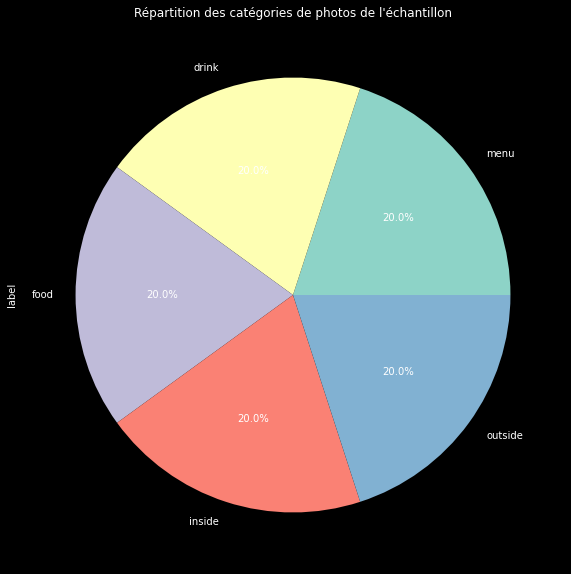

200098 photos importées


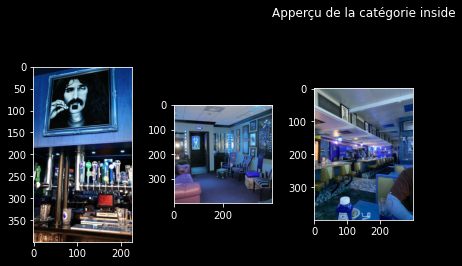

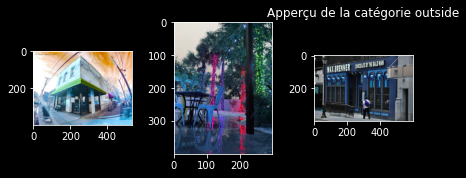

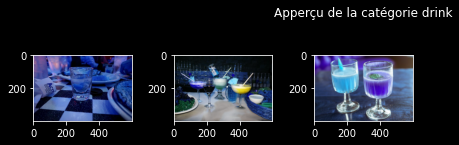

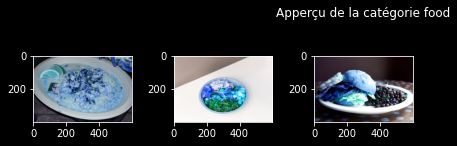

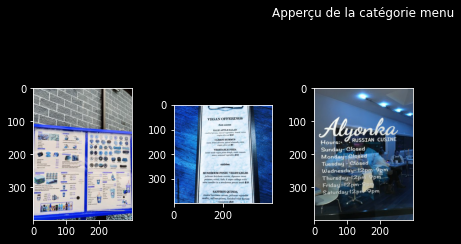

In [8]:
df_photo = import_and_sample(
    path_to_photo_desc,
    path_to_photos,
    sample=100,
    verbose=True,
    plot=True,
    preview=True
)

## Encodage des labels des photos

In [9]:
def encode_photo_labels(df_photo):
    le = preprocessing.LabelEncoder()
    df_photo["encoded_label"] = le.fit_transform(df_photo["label"])
    return df_photo

In [10]:
df_photo = encode_photo_labels(df_photo)
df_photo.head()

,photo_id,business_id,caption,label,image,encoded_label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,./data/photos/zsvj7vloL4L5jhYyPIuVwg.jpg,2
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside,./data/photos/HCUdRJHHm_e0OCTlZetGLg.jpg,4
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,./data/photos/vkr8T0scuJmGVvN2HJelEA.jpg,0
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,./data/photos/pve7D6NUrafHW3EAORubyw.jpg,1
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food,./data/photos/H52Er-uBg6rNrHcReWTD2w.jpg,1


In [11]:
df_photo.groupby("encoded_label").count()

,photo_id,business_id,caption,label,image
encoded_label,,,,,
0,100,100,100,100,100
1,100,100,100,100,100
2,100,100,100,100,100
3,100,100,100,100,100
4,100,100,100,100,100


## Détermination des descripteurs SIFT

In [12]:
def process_sift(impath):
    sift = cv2.xfeatures2d.SIFT_create()
    image = cv2.imread(impath)
    # conversion en nuances de gris
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # égalisation de l'histogramme des images
    image = cv2.equalizeHist(image)
    # détection
    kp, des = sift.detectAndCompute(image, None)
    img = cv2.drawKeypoints(image, kp, image)
    return [kp, des, img]

In [13]:
def sift_all_img(df_photo, verbose=False):
    sift_keypoints = []
    temps1 = time.time()
    sift = cv2.xfeatures2d.SIFT_create()
    ls_photo = df_photo["image"].tolist()
    
    for image_num in range(len(ls_photo)) :
        if image_num%100 == 0:
            print(image_num)
#         image = cv2.imread(ls_photo[image_num])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         res = cv2.equalizeHist(image)
#         kp, des = sift.detectAndCompute(res, None)
        kp, des, img = process_sift(ls_photo[image_num])
        sift_keypoints.append(des)
    
    sift_keypoints_by_img = np.asarray(sift_keypoints)
    sift_keypoints_all = np.concatenate(sift_keypoints_by_img)
    duration = time.time()-temps1
    if verbose:
        print("Nombre de descripteurs : {}".format(sift_keypoints_all.shape))
        print("temps de traitement SIFT descriptor : ", "%15.2f" % duration, "secondes")
    return [sift_keypoints_all, sift_keypoints_by_img]

In [14]:
sift_keypoints_all, sift_keypoints_by_img = sift_all_img(df_photo, verbose=True)

0
100
200
300
400
Nombre de descripteurs : (689367, 128)
temps de traitement SIFT descriptor :            14.01 secondes


C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_13700/1578370475.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


In [15]:
def sift_previews(df, nb_by_cat=3):
    ls_lbls = df["label"].unique().tolist()
    df_preview = df.groupby("label").head(nb_by_cat).sort_values(by="label")
    df_preview = df_preview.reset_index(drop=True)
    for lbl in ls_lbls:
        df_cat = df_preview[df_preview["label"]==lbl].reset_index(drop=True)
        fig, ax = plt.subplots(ncols=nb_by_cat)
        fig.tight_layout()
        plt.title("Apperçu de la catégorie {}".format(lbl), y=1.5)
        for i in range(nb_by_cat):
            plt.subplot(130 + 1 + i)
            filepath = df_cat.iloc[i]["image"]
            kp, des, img = process_sift(filepath)
            img = cv2.drawKeypoints(img, kp, img)
            plt.imshow(img)
        plt.show()
    return

Regardons un apperçu des descripteurs SIFT par catégorie

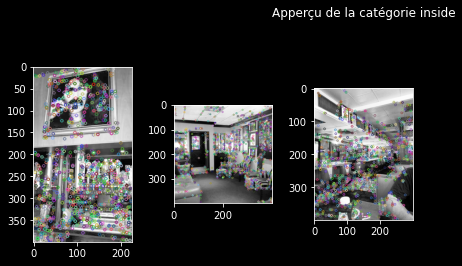

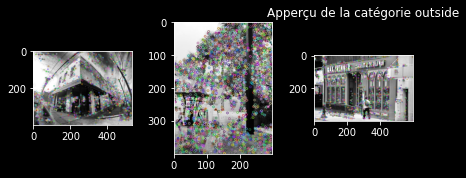

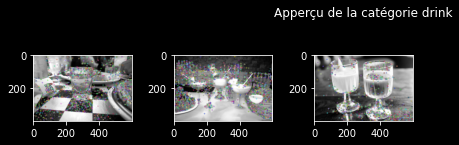

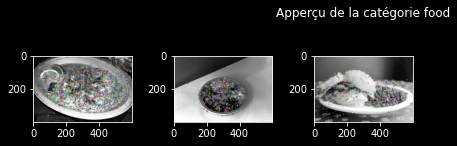

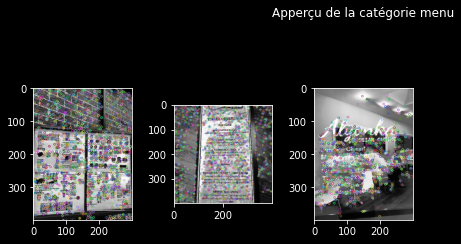

In [16]:
sift_previews(df_photo)

## Création des clusters de descripteurs

In [19]:
temps1=time.time()

# détermination du nombre 
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : {}".format(k))
print("Création de {} clusters descripteurs ...".format(k))

# Clustering
kmeans = cluster.MiniBatchKMeans(
    n_clusters=k,
    init_size=3*k,
    random_state=0
)
kmeans.fit(sift_keypoints_all)


duration=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration, "secondes")

Nombre de clusters estimés : 830
Création de 830 clusters descripteurs ...


C:\Users\Utilisateur\anaconda3\envs\OC_P06\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :             8.74 secondes


## Création des features des images

In [20]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("Problême histogramme image : {}".format(image_num))
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [21]:
def calc_img_features(kmeans, sift_keypoints_by_img, verbose=False):
    temps1=time.time()
    if verbose:
        print("Création des histogrammes...")
    
    # Creation de la matrice d'histogrammes
    hist_vectors = []

    for i, image_desc in enumerate(sift_keypoints_by_img):
        if i%100 == 0:
            print(i)
        hist = build_histogram(kmeans, image_desc, i) # calcule l'histogramme
        hist_vectors.append(hist) # histogram is the feature

    im_features = np.array(hist_vectors)

    duration1 = time.time()-temps1
    if verbose:
        print("Temps de création des histogrammes : {} secondes".format(duration1))
    return im_features

In [22]:
im_features = calc_img_features(kmeans, sift_keypoints_by_img, verbose=True)

Création des histogrammes...
0
100
200
300
400
Temps de création des histogrammes : 15.774497985839844 secondes


## Réduction de dimension

### PCA

In [23]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (500, 830)
Dimensions dataset après réduction PCA :  (500, 394)


### T-SNE

In [24]:
tsne = manifold.TSNE(
    n_components=2, 
    perplexity=30, 
    n_iter=2000, 
    init='random', 
    random_state=6
)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_photo["label"]
print(df_tsne.shape)

C:\Users\Utilisateur\anaconda3\envs\OC_P06\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(500, 3)


#### T-SNE :  affichage selon label d'images

In [59]:
def plot_tsne(df_photo, df_tsne, hue, title=None):
    n_colors = len(df_photo["label"].unique().tolist())
    if title==None:
        title='TSNE selon les vrais labels'

    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", 
        y="tsne2", 
        hue=hue, 
        data=df_tsne, 
        legend="brief",
        palette=sns.color_palette('tab10', n_colors=n_colors), 
        s=50, 
        alpha=0.6
    )

    plt.title(
        title, 
        fontsize = 30, 
        pad = 35, 
        fontweight = 'bold'
    )
    plt.xlabel(
        'tsne1', 
        fontsize = 26, 
        fontweight = 'bold'
    )
    plt.ylabel(
        'tsne2', 
        fontsize = 26, 
        fontweight = 'bold'
    )
    plt.legend(prop={'size': 14}) 

    plt.show()

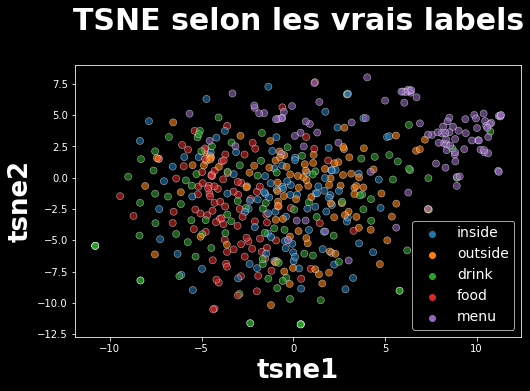

In [26]:
plot_tsne(df_photo, df_tsne, "class")

In [43]:
pickle.dump(df_photo, open(sav_path+dash_prefix+"df_photo", "wb"))
pickle.dump(df_tsne, open(sav_path+dash_prefix+"df_tsne", "wb"))

### Similarité entre catégories et clusters

### Clusters à partir du T-SNE

In [27]:
def tsne_clustering(X_tsne, df_tsne):
    cls = cluster.KMeans(n_clusters=5, random_state=6)
    cls.fit(X_tsne)

    df_tsne["cluster"] = cls.labels_
    return df_tsne

In [28]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(500, 4)


### Visualisation images selon cluster

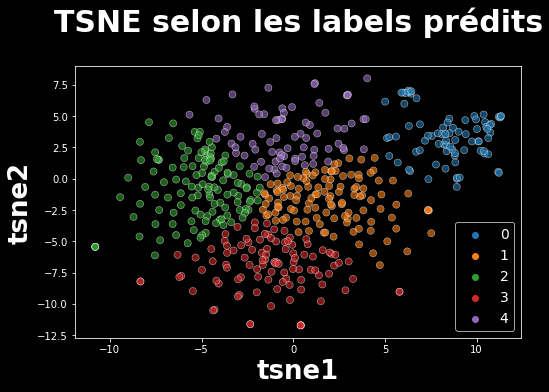

In [60]:
plot_tsne(df_photo, df_tsne, "cluster", title="TSNE selon les labels prédits")

#### ARI

In [69]:
ari_score_1 = metrics.adjusted_rand_score(df_photo["encoded_label"], cls.labels_)

In [30]:
print("ARI : ", metrics.adjusted_rand_score(df_photo["encoded_label"], cls.labels_))

ARI :  0.16138764534786712


Ce score semble assez faible

In [70]:
pickle.dump(cls, open(sav_path+dash_prefix+"cls", "wb"))
pickle.dump(ari_score_1, open(sav_path+dash_prefix+"ari_score_1", "wb"))

## Analyse par classe

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [32]:
confusion_matrix = metrics.confusion_matrix(df_photo["encoded_label"], cls.labels_)

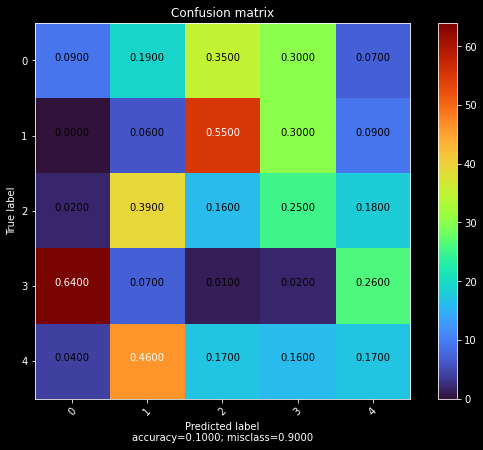

In [33]:
plot_confusion_matrix(confusion_matrix, [0, 1, 2, 3, 4], cmap="turbo")

La précision est assez faible. On notera toutefois que les labels déterminés par notre modèle ne sont pas mappés de la même manière que les vrais labels encodés. Par exemple, ce que notre modèle désignera comme le label 0 pourrait correspondre au label 4 dans nos données (c'est juste un exemple).

Remappons donc les labels prédits. Pour trouver automatiquement le mapping qui convient, il s'agit de permuter les lignes de notre matrice de confusion de manière à maximiser la somme de sa diagonale (de la première ligne/première colonne à la dernière ligne/dernière colonne). Nous aurons donc un score d'accuracy plus proche de la réalité. Néanmoins, ça n'aura aucune incidence sur l'ARI.

[[64  7  1  2 26]
 [ 4 46 17 16 17]
 [ 0  6 55 30  9]
 [ 9 19 35 30  7]
 [ 2 39 16 25 18]]


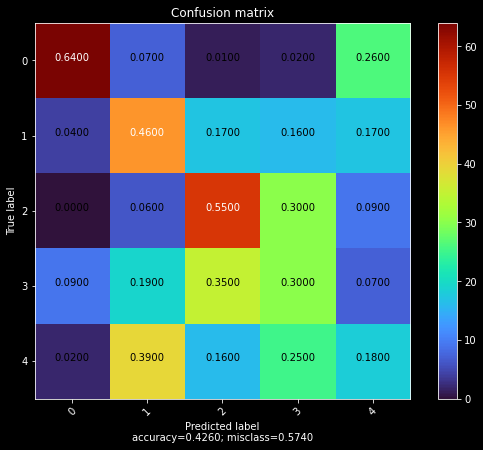

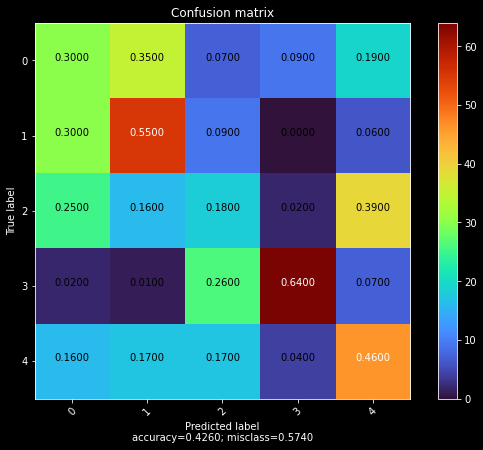

In [34]:
def get_diagonal(mat):
    ls = []
    for i in range(len(mat)):
        ls.append(mat[i][i])
    return ls

def reorder_labels(confusion_matrix, verbose=False):
    scores = []
    indexes = range(len(confusion_matrix))
    permutations = list(itertools.permutations(indexes, len(indexes)))
    for i in range(len(permutations)):
        new_matrix = [list(confusion_matrix[j]) for j in permutations[i]]
        score = sum(get_diagonal(new_matrix))
        scores.append(score)
    max_score = max(scores)
    max_index = scores.index(max_score)
    best_permutation = permutations[max_index]
    if verbose:
        print("meilleure combinaison : {}".format(best_permutation))
        print("meilleure somme de diagonale : {}".format(max_score))
    new_matrix = [list(confusion_matrix[i]) for i in permutations[max_index]]
    new_matrix = np.array(new_matrix)
    return [new_matrix, best_permutation]
reordered_conf_mat, best_permutation = reorder_labels(confusion_matrix)
print(reordered_conf_mat)

def replace_labels(true_labels, predicted_labels, verbose=False):
    corrected_labels = predicted_labels
    confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
    reordered_conf_mat, best_permutation = reorder_labels(confusion_matrix)
    corrected_labels = np.array([x+len(confusion_matrix) for x in corrected_labels])
    initial_labels_order_augm = [x+len(confusion_matrix) for x in range(len(confusion_matrix))]
    for i in range(len(best_permutation)):
        label_to_change = initial_labels_order_augm[i]
        corrected_labels[corrected_labels==label_to_change]=best_permutation[i]
        if verbose:
            print("le label {} est remplacé par {}".format(
                    label_to_change-len(confusion_matrix), 
                    best_permutation[i])
                 )
    return corrected_labels

plot_confusion_matrix(reordered_conf_mat, [0, 1, 2, 3, 4], cmap="turbo")
corrected_labels = replace_labels(df_photo["encoded_label"], cls.labels_)
new_confusion_matrix = metrics.confusion_matrix(df_photo["encoded_label"], corrected_labels)
plot_confusion_matrix(new_confusion_matrix, [0, 1, 2, 3, 4], cmap="turbo")

In [44]:
pickle.dump(new_confusion_matrix, open(sav_path+dash_prefix+"new_confusion_matrix", "wb"))

## Tranfer Learning avec un CNN

In [49]:
def get_vgg16_model(layer='fc2'):
    """Modèle Keras du réseau VGG16, avec la couche de sortie définie sur `layer`. 
    Le layer par défaut est l'avant-dernier layer entièrement connecté 'fc2' de forme (4096,)..
    Parameters
    ----------
    layer : str
        quel layer extraire (doit être de forme (None, X)), e.g. 'fc2', 'fc1'
        ou 'flatten'
    """
    base_model = VGG16(
        weights='imagenet', 
        include_top=True
    )
    model = Model(
        inputs=base_model.input,
        outputs=base_model.get_layer(layer).output
    )
    return model

In [50]:
vgg16_model = get_vgg16_model()

In [51]:
display(HTML("<h1>Architecture du réseau VGG16</h1>"))
vgg16_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

   ### Extraction de features

In [52]:
df_photo.head()

,photo_id,business_id,caption,label,image,encoded_label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,./data/photos/zsvj7vloL4L5jhYyPIuVwg.jpg,2
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside,./data/photos/HCUdRJHHm_e0OCTlZetGLg.jpg,4
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,./data/photos/vkr8T0scuJmGVvN2HJelEA.jpg,0
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,./data/photos/pve7D6NUrafHW3EAORubyw.jpg,1
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food,./data/photos/H52Er-uBg6rNrHcReWTD2w.jpg,1


In [53]:
def build_features_transfer_learning(
    df_photo,
    path_column_name,
    model,
    verbose=False
):
    features = []
    if verbose:
        print("Extraction des features...")
    for index in range(len(df_photo)) :
        photo_path = df_photo.iloc[index][path_column_name]

        photo = cv2.imread(photo_path)
        photo = cv2.resize(photo, (224, 224)) 
    
        photo = np.expand_dims(photo, axis=0)  
        photo = preprocess_input(photo)
    
        features_predict = model.predict(photo)
        features_predict_flatten = features_predict.flatten()
    
        features.append(features_predict_flatten)
    
    photos_features = np.asarray(features)
    
    if verbose:
        print("Création des features de  photos terminé")
    
    return photos_features

In [71]:
def transfer_learning(
    df_photo,
    path_column_name,
    model, 
    verbose=False
):
    # creation des features
    photos_features = build_features_transfer_learning(
        df_photo, 
        path_column_name,
        model,
        verbose=verbose
    )
    
    # ACP pour réduction dimensionnelle
    if verbose :
        print("réduction dimensionnelle via PCA...")
        print("Dimensions dataset avant réduction PCA : {}".format(photos_features.shape))
    pca = decomposition.PCA(n_components=0.99)
    feat_pca= pca.fit_transform(photos_features)
    if verbose :
        print("Dimensions dataset après réduction PCA : {}".format(feat_pca.shape))
        
    # T-SNE pour réduction dimensionnelle
    if verbose :
        print("réduction dimensionnelle via T-SNE...")
    tsne = manifold.TSNE(
        n_components=2, 
        perplexity=30, 
        n_iter=2000, 
        init='random', 
        random_state=6
    )
    X_tsne = tsne.fit_transform(feat_pca)
    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = df_photo["label"]
    if verbose :
        print("Dimensions dataset après T-SNE : {}".format(df_tsne.shape))
    
    # visualisation T-SNE
    plot_tsne(df_photo, df_tsne, "class")
    
    # clustering T-SNE
    df_tsne = tsne_clustering(X_tsne, df_tsne)
    
    # visualisation T-SNE clusters
    plot_tsne(df_photo, df_tsne, "cluster", "TSNE selon les labels prédits")
    
    # ARI Score
    score_ari = metrics.adjusted_rand_score(df_photo["encoded_label"], df_tsne['cluster'])
    pickle.dump(score_ari, open(sav_path+dash_prefix+"score_ari_cnn", "wb"))
    if verbose :
        print("Score ARI - Transfer Learning = {}".format(score_ari))
    return photos_features, df_photo, df_tsne

Extraction des features...
Création des features de  photos terminé
réduction dimensionnelle via PCA...
Dimensions dataset avant réduction PCA : (500, 4096)
Dimensions dataset après réduction PCA : (500, 440)
réduction dimensionnelle via T-SNE...


C:\Users\Utilisateur\anaconda3\envs\OC_P06\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimensions dataset après T-SNE : (500, 3)


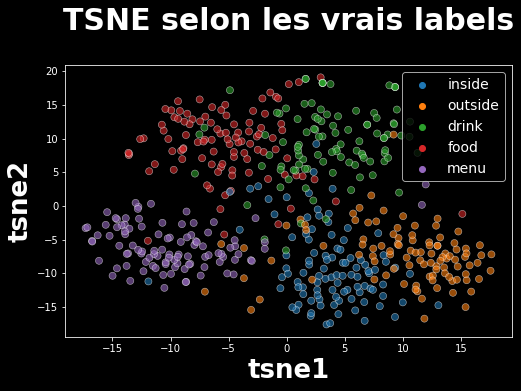

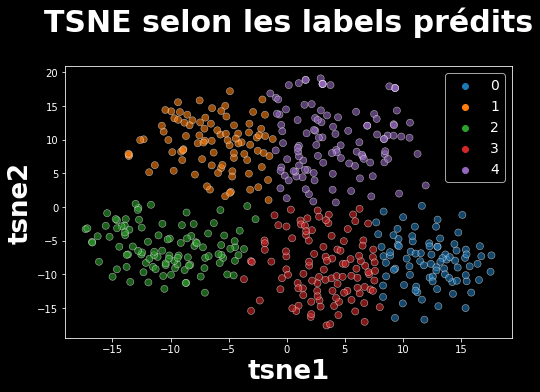

Score ARI - Transfer Learning = 0.6284201201026421


In [72]:
photo_features_cnn, df_photo, df_tsne_cnn = transfer_learning(
    df_photo,
    "image",
    vgg16_model, 
    verbose=True
)

In [74]:
pickle.dump(photo_features_cnn, open(sav_path+dash_prefix+"photo_features_cnn", "wb"))
pickle.dump(df_tsne_cnn, open(sav_path+dash_prefix+"df_tsne_cnn", "wb"))
pickle.dump(df_photo, open(sav_path+dash_prefix+"df_photo", "wb"))

,photo_id,business_id,caption,label,image,encoded_label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,./data/photos/zsvj7vloL4L5jhYyPIuVwg.jpg,2
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside,./data/photos/HCUdRJHHm_e0OCTlZetGLg.jpg,4
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,./data/photos/vkr8T0scuJmGVvN2HJelEA.jpg,0
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,./data/photos/pve7D6NUrafHW3EAORubyw.jpg,1
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food,./data/photos/H52Er-uBg6rNrHcReWTD2w.jpg,1
